<a href="https://colab.research.google.com/github/Wazzabeee/NLP_Unsupervised_Sentiment_Analysis_Elon_Musk/blob/main/500_000_Tweets_on_Elon_Musk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing libraries

In [4]:
!pip install wordcloud
!pip install emot
!pip install TextBlob
!pip install contractions
!pip install chart-studio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 2.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 10.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 2.5 MB/s eta 0:00:00


# Importing everything we need

In [5]:
import chart_studio
import re
import string
import emot
import collections
import ipywidgets
import contractions
import cufflinks
import nltk.tokenize

import chart_studio.plotly as py
import chart_studio.tools as tls
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np

from textblob import TextBlob
from google.colab import widgets
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

In [6]:
username='vishwa2405'
api_key='GS3nCiRKRonSMYkPuWN9'

chart_studio.tools.set_credentials_file(username=username,
                                        api_key=api_key)

pd.set_option('display.max_colwidth', None)

nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

sid = SentimentIntensityAnalyzer()
emot_obj = emot.core.emot()

cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

pio.renderers.default = 'colab'

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


# First look at the data

In [7]:
df = pd.read_json('data_503986.json')
df.sample(n=10)

id  \
181211  1601189872467079168   
59346   1599238195304361984   
133391  1600402034515398657   
27840   1598682013397131264   
164457  1600793393546039297   
34170   1598816671493656576   
336259  1603458369276317697   
298875  1602756864780935169   
74841   1599553980497276928   
240032  1601937247250563073   

                                                                                                                                                                                                                                                                                                                                           text  
181211  @signal_bnb @elonmusk @Twitter @TWDOGE__BSC 🚨STEALTH LAUNCHED TRUMPLON ON #BSC🚨\n\n✅LP LOCKED\n✅#BUSD  rewards\n✅Experienced team\n✅Low starting LP\n✅ NO PRESALE NO PRIVATE NO TEAM TOKENS \n✅50% burned \n\n#trumplon $trumplon #trump #ELONMUSK \n\nhttps://t.co/6bjlau158X\n\nhttps://t.co/ujPGsy1ZPA\n6717 https://t.co/PCVb0Rayak  
59346                                                                                                                                                                                                                    @elonmusk  I have never had a twitter. I do now because I believe in what you’ve done here for real! I’m proud of you!  
133391                                                                                                                                                                                               @LevineJonathan @elonmusk What if I made a bunch of paper airplanes and threw them at you, slowly giving you papercuts until you bleed out  
27840                                                                                                                                                                                                                                     @elonmusk @shortword @M3Marcel @WholeMarsBlog Are you unbanning ppl still or did you change your mind  
164457                                                                                                                                                                                                                                                    @AlessioCrypto @elonmusk @kadena_io If BTC Never achieve it all the crypto will fail.  
34170                                                                                                                                                                                                                                                                                @elonmusk Can’t wait, karma a bitch , she’s coming for you  
336259                                                                                                                                                                                                                                                                         @MrAndyNgo @elonmusk These conservative nazis need to be stopped  
298875                                                                                                                                                               @BabyTheCat1 @stephenstwittor @Twitter @Tesla @chevrolet @elonmusk Ummm $.010 kw $16.00 for 330 miles or $4.00 a gal $80 for 300 miles  seems like gasoline is WAY cheaper  
74841                                                                                                                                                                                                                                                                                               @elonmusk @pmarca It's the correct opinion.  
240032                                                                                                                                                                            @elonmusk While you’re getting rid of bot’s perhaps you could delete Profmatthewwolf. It’s been blocked for 2 1/2 years and t

## Pre-processing

In [8]:
def pre_process(text):
    # Remove links
    text = re.sub('http://\S+|https://\S+', '', text)
    text = re.sub('http[s]?://\S+', '', text)
    text = re.sub(r"http\S+", "", text)

    text = re.sub('&amp', 'and', text)
    text = re.sub('&lt', '<', text)
    text = re.sub('&gt', '>', text)

    # Remove new line characters
    text = re.sub('[\r\n]+', ' ', text)

    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)

    # Remove multiple space characters
    text = re.sub('\s+',' ', text)
    
    # Convert to lowercase
    text = text.lower()
    return text

In [9]:
df['processed_text'] = df['text'].apply(pre_process)

In [10]:
df.sample(n=5)

id  \
113580  1600150475185147904   
383741  1604257257620791296   
297774  1602743107518275584   
7994    1597929550062981122   
328953  1603411745560739840   

                                                                                                                                                                                                                                                                                                                            text  \
113580                                                                                                                                                                                                                                                                                        @elonmusk Can I have a tenner mate   
383741                                                                                                                                                                                                                                                                         @elonmusk elon home address is public information   
297774             @SpaceX @elonmusk hit can be used to 'swamp up' the little particles. \n\nAnd instead of wasting the waste products (eg by letting them burn up in the atmosphere) use them (or their atoms!) as resources in orbit. E.g. when you build the orbital space factory as the first step towards Mars \nAD ASTRA!   
7994    @cz_binance @elonmusk @cz_binance @VitalikButerin @TheCryptoLark @CryptoKemal @kriptoemre @WatcherGuru \n@OokiTrade @harvest_finance \nNEXT  PUMP\n\n#OOKI           #VGX            #FET\n\n#FARM          #XEC            #HODL \n\n#Binance  #HuobiGlobal\n#Gateio #KuCoin   \n\n🐳🐳🐳💯💯💯💵💵💵🚀🚀🚀 https://t.co/xMjMmzefWl   
328953                                                                                        The sale comes as shares of the electric vehicle and solar panel maker have collapsed, losing over half their value since Musk first disclosed in April that he was buying up Twitter stock. https://t.co/pzjZSbnPDG via @HuffPost   

                                                                                                                                                                                                                                                                                processed_text  
113580                                                                                                                                                                                                                                                                can i have a tenner mate  
383741                                                                                                                                                                                                                                                 elon home address is public information  
297774   hit can be used to 'swamp up' the little particles. and instead of wasting the waste products (eg by letting them burn up in the atmosphere) use them (or their atoms!) as resources in orbit. e.g. when you build the orbital space factory as the first step towards mars ad astra!  
7994                                                                                                                                                                                                                                                                   next pump 🐳🐳🐳💯💯💯💵💵💵🚀🚀🚀   
328953                                                                                       the sale comes as shares of the electric vehicle and solar panel maker have collapsed, losing over half their value since musk first disclosed in april that he was buying up twitter stock. via

## N-Grams


In [11]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(df['processed_text'], 20)

df1 = pd.DataFrame(common_words, columns = ['TweetText' , 'count'])
df1.groupby('TweetText').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar',
    yTitle='Count',
    linecolor='black',
    title='Top 20 bigrams in Tweet before removing spams')

## Removing spams

In [12]:
to_drop = ["LP LOCKED", "accumulated 1 ETH","This guy accumulated over $100K", "help me sell a nickname", "As A Big Fuck You To The SEC", "Wanna be TOP G", "#walv", "#NFTProject", "#1000xgem", "$GALI", "NFT", "What the Soul of USA is", "#BUSD", "$FXMS", "#fxms", "#Floki", "#FLOKIXMAS", "#memecoin", "#lowcapgem", "#frogxmas", "Xmas token", "crypto space", "Busd Rewards", "TRUMPLON", "NO PRESALE", "#MIKOTO", "$HATI", "$SKOLL", "#ebaydeals", "CHRISTMAS RABBIT", "@cz_binance", "NFT Airdrop", "#NFT"]

In [13]:
df = df[~df['text'].str.contains('|'.join(to_drop))]

## Expanding contractions + drop ID

In [14]:
def expand_contractions(text):
  try:
    return contractions.fix(text)
  except:
    return text

In [15]:
df['expanded_text'] = df['text'].apply(expand_contractions)
df['processed_text'] = df['expanded_text'].apply(pre_process)
df = df.drop('id', axis=1)

In [16]:
df.sample(n=3)

text  \
15711                                                                @elonmusk Lot of fake people on here   
331278  @lavern_spicer @elonmusk People are afraid of the fire hose if lies that are going to come forth.   
185029    @KlenderJoey @Teslarati @Tesla #Legendary exchange!!Thank you very much https://t.co/W58xAutKbU   

                                                                   processed_text  \
15711                                                  lot of fake people on here   
331278   people are afraid of the fire hose if lies that are going to come forth.   
185029                                             exchange!!thank you very much    

                                                                                            expanded_text  
15711                                                                @elonmusk Lot of fake people on here  
331278  @lavern_spicer @elonmusk People are afraid of the fire hose if lies that are going to come forth.  
185029    @KlenderJoey @Teslarati @Tesla #Legendary exchange!!Thank you very much https://t.co/W58xAutKbU

## Bi-grams without spam, stop words and Elon Musk

In [17]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(df['processed_text'], 21)
common_words = common_words[1:]

for word, freq in common_words:
    print(word, freq)

df4 = pd.DataFrame(common_words, columns = ['TweetText' , 'count'])
df4.groupby('TweetText').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in Tweet after removing spams')

free speech 10228
social media 3031
twitter files 2752
hate speech 1898
freedom speech 1888
just like 1850
right wing 1715
looks like 1650
hunter biden 1619
musk twitter 1527
people like 1382
sounds like 1208
mr musk 1177
does mean 1120
real time 1068
donald trump 1029
thank elon 942
like elon 913
twitter ceo 897
did know 890


## Tri-grams without spam and stop words

In [18]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_trigram(df['processed_text'], 20)

for word, freq in common_words:
    print(word, freq)

df6 = pd.DataFrame(common_words, columns = ['TweetText' , 'count'])
df6.groupby('TweetText').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar',
    yTitle='Count',
    linecolor='black',
    title='The 20 most frequent tri-grams in the dataset (without stopwords and spams)')

elon musk twitter 1365
elon musk says 618
hunter biden laptop 557
twitter elon musk 520
like elon musk 508
elon musk just 507
social media platform 367
thank elon musk 339
real time location 298
free speech absolutist 276
think elon musk 275
mentioned million times 252
million times muted 252
elon musk neuralink 247
richest man world 243
free speech twitter 240
elon need help 239
elon musk does 232
need help maybe 228
help maybe funny 228


# WordClouds

## Unigrams

In [19]:
# Initialize Lemmatize
wordnet_lem = WordNetLemmatizer()

# Lemmatize processed text and join everything in a list
df['text_lem'] = df['processed_text'].apply(wordnet_lem.lemmatize)
all_words_lem = ' '.join([word for word in df['text_lem']])

In [23]:
# Generate a word cloud image
mask = np.array(Image.open("/content/twitter-logo-bird-1500x500-1.jpg"))
stopwords = set(STOPWORDS)

wordcloud_twitter = WordCloud(height=2000,
                              width=2000,
                              background_color="white",
                              mode="RGBA",
                              stopwords=stopwords,
                              mask=mask).generate(all_words_lem)

# Create coloring from the image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[20,20])
plt.axis('off')
plt.tight_layout(pad=0)
plt.imshow(wordcloud_twitter.recolor(color_func=image_colors), interpolation="bilinear")

# Store visualization to file
plt.savefig("twitter_logo_unigram.png", format="png")

plt.show()

## Mentions

In [24]:
# Retrieves all occurrences of @+text
df['mentions'] = df['text'].str.findall(r'@\w+')
# Removes the @ in front
df['mentions'] = [list(map(lambda x: x[1:], mentions)) for mentions in df['mentions']]
# Converts the list of words in each row to a string
df['mentions_string'] = df['mentions'].apply(lambda x: ' '.join(x))
# Concatenates all strings in one string
all_mentions = ' '.join([word for word in df['mentions_string']])

### With Elon Musk

In [36]:
# Generate a word cloud image
mask = np.array(Image.open("/content/twitter-logo-bird-1500x500-1.jpg"))
stopwords = set(STOPWORDS)

wordcloud_twitter = WordCloud(height=2000,
                              width=2000,
                              background_color="white",
                              mode="RGBA",
                              stopwords=stopwords,
                              collocations = False,
                              mask=mask).generate(all_mentions)

# Create coloring from the image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[20,20])
plt.axis('off')
plt.tight_layout(pad=0)
plt.imshow(wordcloud_twitter.recolor(color_func=image_colors), interpolation="bilinear")

# Store visualization to file
plt.savefig("twitter_logo_mentions.png", format="png")

plt.show()

### Without Elon Musk

In [37]:
word_to_remove = "elonmusk"
new_string = ""

for word in all_mentions.split():
    if word != word_to_remove:
        new_string += word + " "

new_string = new_string.strip()

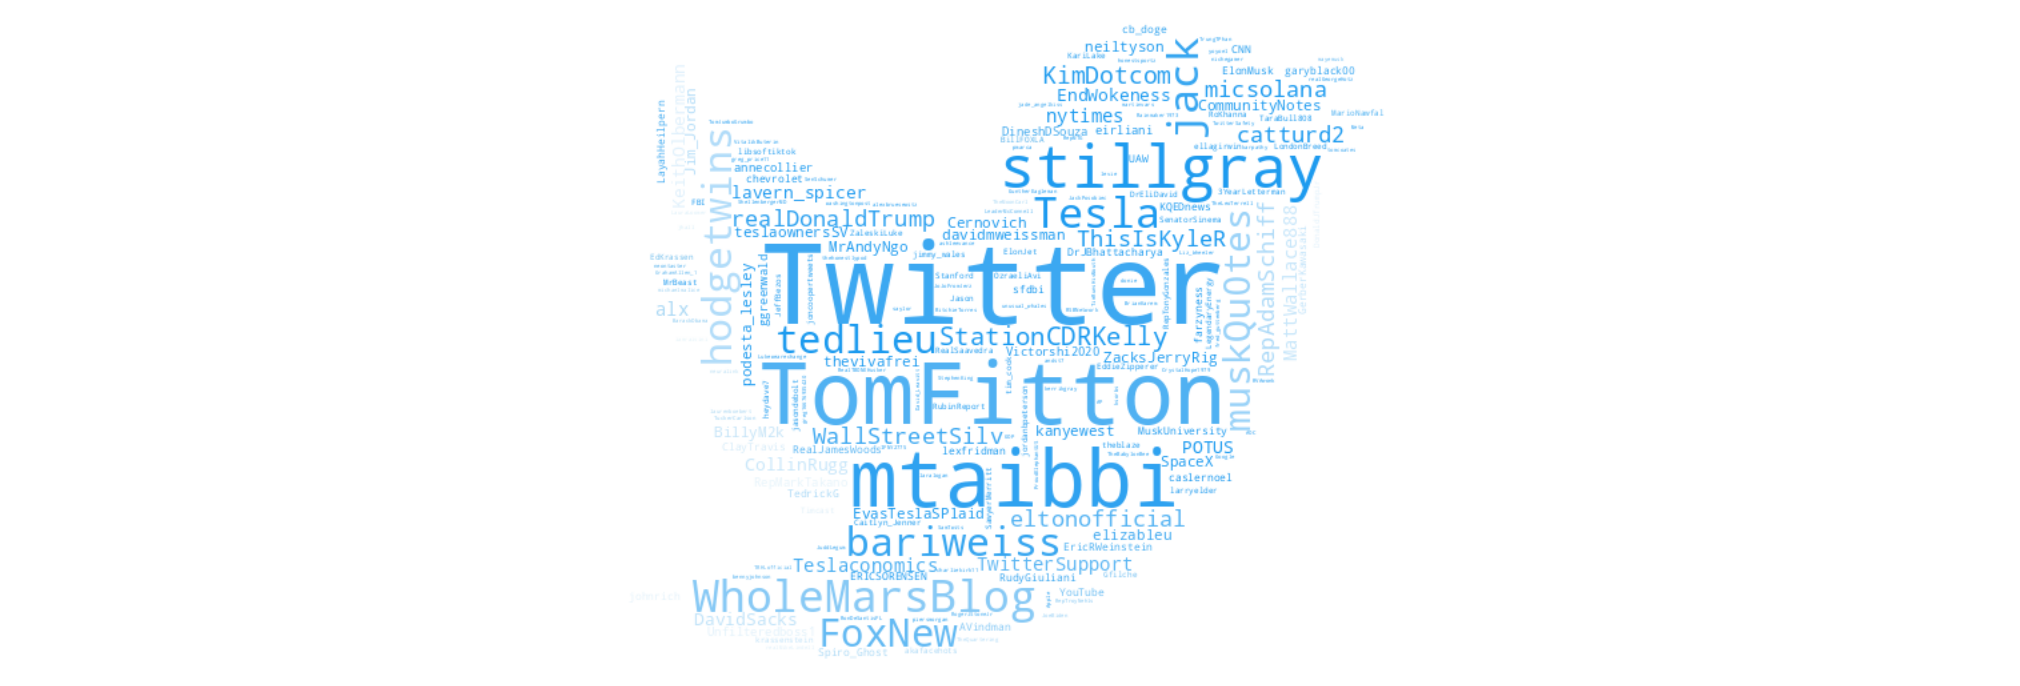

In [39]:
# Generate a word cloud image
mask = np.array(Image.open("/content/twitter-logo-bird-1500x500-1.jpg"))
stopwords = set(STOPWORDS)

wordcloud_twitter = WordCloud(height=2000,
                              width=2000,
                              background_color="white",
                              mode="RGBA",
                              stopwords=stopwords,
                              collocations = False,
                              mask=mask).generate(new_string)

# Create coloring from the image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[20,20])
plt.axis('off')
plt.tight_layout(pad=0)
plt.imshow(wordcloud_twitter.recolor(color_func=image_colors), interpolation="bilinear")

# Store visualization to file
plt.savefig("twitter_logo_mentions_wo_elon.png", format="png")

plt.show()

## Emojis

In [40]:
# Define a function to extract emoticons
def extract_emoticons(text):
  res = emot_obj.emoji(text)
  return res['value']

In [41]:
# Apply the function to each row of the 'text' column
df['emoticons'] = df['text'].apply(extract_emoticons)

Issue with internal pattern finding emoji: '🇬'


In [42]:
df['emoticons'].apply(lambda x: collections.Counter(x))
combined_counts = sum(df['emoticons'].apply(lambda x: collections.Counter(x)), collections.Counter())
emoji_dict = dict(combined_counts)
sorted_emoji_dict = dict(sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True))

In [43]:
d = {k: v for i, (k, v) in enumerate(sorted_emoji_dict.items()) if i < 20}
df_emojis = pd.DataFrame(list(d.items()), columns=['Emojis', 'Count'])
df_emojis.at[5, 'Emojis'] = '❤️'
df_emojis.at[6, 'Emojis'] = '🤡'

In [44]:
df_emojis.groupby('Emojis').sum()['Count'].sort_values(ascending=False).iplot(
    kind='bar',xTitle='Emojis', yTitle='Count', linecolor='black', title='The 20 most used emojis after removing spam')

# Unsupervised Sentiment Analysis

## Getting polarities

In [28]:
df['vader_polarity'] = df['processed_text'].map(lambda text: sid.polarity_scores(text)['compound'])
df['blob_polarity'] = df['processed_text'].map(lambda text: TextBlob(text).sentiment.polarity)

In [29]:
new_df = df[['vader_polarity', 'blob_polarity']]
new_df = new_df.rename(columns={'vader_polarity': 'Vader', 'blob_polarity': 'TextBlob'})

## Comparison between Vader and TextBlob

In [30]:
new_df.iplot(
    kind='hist',
    bins=40,
    xTitle='Polarity',
    linecolor='black',
    yTitle='Count',
    title='Comparison of the distributions of sentimental polarities',
    colors = ['#1DA1F2', '#EB8C17'],
    barmode="group")

## Stats

In [31]:
new_df.describe()

Vader       TextBlob
count  487047.000000  487047.000000
mean        0.040615       0.067221
std         0.456807       0.289077
min        -0.999600      -1.000000
25%        -0.296000       0.000000
50%         0.000000       0.000000
75%         0.401900       0.200000
max         0.998200       1.000000

## Topic analysis

In [32]:
stop_words = nltk.corpus.stopwords.words('english')

def remove_stop_words(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    return ' '.join([word for word in text.split() if word.lower() not in stop_words])

df['stop_text'] = df['processed_text'].apply(lambda x: remove_stop_words(x))

In [33]:
# We define a list of topics
topics = ['free speech',
          'hunter biden',
          'twitter files',
          'freedom speech', 
          'right wing',
          'donald trump']

vader_sentiments = df['vader_polarity'].tolist()
textblob_sentiments = df['blob_polarity'].tolist()
text = df['stop_text'].tolist()

# We create a new column Topic
df['Topic'] = ""
for topic in topics:
    df.loc[df['stop_text'].str.contains(topic), 'Topic'] = topic

# We create a new DataFrame with columns topic / sentiment / source
data = []
for topic in topics:
    topic_rows = df[df['Topic'] == topic]
    # Average sentiment per topic
    vader_sentiments = topic_rows['vader_polarity'].sum() / topic_rows.shape[0]
    textblob_sentiments = topic_rows['blob_polarity'].sum() / topic_rows.shape[0]
    # Append data
    data.append({'Topic': topic, 'Sentiment': vader_sentiments, 'Source': 'Vader'})
    data.append({'Topic': topic, 'Sentiment': textblob_sentiments, 'Source': 'TextBlob'})

df_new = pd.DataFrame(data)

# Plot the sentiment for each topic
fig = px.bar(df_new,
             x='Topic',
             y='Sentiment',
             color='Source',
             barmode='group',
             color_discrete_sequence = ['#1DA1F2', '#EB8C17'],
             title='Comparative sentimental analysis by topic',
             template='plotly_white')

fig.update_traces(marker_line_width=1,
                  marker_line_color="black")

fig.show()

## Personalities

In [34]:
usernames = ['@Tesla', '@TomFitton', '@FoxNews', '@realDonaldTrump' , '@TwitterSupport', '@nytimes']
vader_sentiments = df['vader_polarity'].tolist()
textblob_sentiments = df['blob_polarity'].tolist()
text = df['text'].tolist()

# create a new column for the username
df['Mention'] = ""
for username in usernames:
    df.loc[df['text'].str.contains(username), 'Mention'] = username

# create a new dataframe with columns for username, sentiment, and sentiment source
data = []
for username in usernames:
    username_rows = df[df['Mention'] == username]
    vader_sentiments = username_rows['vader_polarity'].sum() / username_rows.shape[0]
    textblob_sentiments = username_rows['blob_polarity'].sum() / username_rows.shape[0]
    data.append({'Mention': username, 'Sentiment': vader_sentiments, 'Source': 'Vader'})
    data.append({'Mention': username, 'Sentiment': textblob_sentiments, 'Source': 'TextBlob'})
df_new = pd.DataFrame(data)

# plot the sentiment for each username using Plotly
fig = px.bar(df_new,
             x='Mention',
             y='Sentiment',
             color='Source',
             barmode='group',
             color_discrete_sequence = ['#1DA1F2', '#EB8C17'],
             title='Comparative sentimental analysis by accounts',
             template='plotly_white')

fig.update_traces(marker_line_width=1,
                  marker_line_color="black")

fig.show()

## Trigrams

In [35]:
tri_grams = ['hunter biden laptop',
             'elon musk twitter',
             'real time location',
             'free speech absolutist',
             'free speech twitter']
vader_sentiments = df['vader_polarity'].tolist()
textblob_sentiments = df['blob_polarity'].tolist()
text = df['text'].tolist()

# create a new column for the username
df['Trigram'] = ""
for trigram in tri_grams:
    df.loc[df['text'].str.contains(trigram), 'Trigram'] = trigram

# create a new dataframe with columns for username, sentiment, and sentiment source
data = []
for trigram in tri_grams:
    trigram_rows = df[df['Trigram'] == trigram]
    vader_sentiments = trigram_rows['vader_polarity'].sum() / trigram_rows.shape[0]
    textblob_sentiments = trigram_rows['blob_polarity'].sum() / trigram_rows.shape[0]
    data.append({'Trigram': trigram, 'Sentiment': vader_sentiments, 'Source': 'Vader'})
    data.append({'Trigram': trigram, 'Sentiment': textblob_sentiments, 'Source': 'TextBlob'})
df_new = pd.DataFrame(data)

# plot the sentiment for each username using Plotly
fig = px.bar(df_new,
             x='Trigram',
             y='Sentiment',
             color='Source',
             barmode='group',
             color_discrete_sequence = ['#1DA1F2', '#EB8C17'],
             title='Emotional analysis of the most present tri-grams',
             template='plotly_white')

fig.update_traces(marker_line_width=1,
                  marker_line_color="black")

fig.show()

In [57]:
import pandas as pd
from textblob import TextBlob

# Load the dataset into a DataFrame
df = pd.read_json('/content/data_503986.json')

# Perform text sentiment analysis using TextBlob
df['sentiment_polarity'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['sentiment_subjectivity'] = df['text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# Define a function to categorize sentiment based on polarity score
def get_sentiment_category(score):
    if score > 0:
        return 'Positive'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Negative'

# Apply the sentiment category function to create a 'sentiment' column
df['sentiment'] = df['sentiment_polarity'].apply(get_sentiment_category)

# Calculate counts of different sentiments
sentiment_counts = df['sentiment'].value_counts()

# Print the sentiment counts
print('Sentiment Counts:')
print(sentiment_counts)


Sentiment Counts:
Neutral     199991
Positive    199961
Negative    104034
Name: sentiment, dtype: int64


In [50]:
df

id  \
0       1596647314030231552   
1       1596647313887346689   
2       1596647313719853056   
3       1596647313346215941   
4       1596647312746754048   
...                     ...   
503981  1615836342079954960   
503982  1615836341660524564   
503983  1615836340758904832   
503984  1615836340490313759   
503985  1615836339412553730   

                                                                                                                                                                                                                                                                              text  \
0                                                                                                                                                                                                             @DonutOperator @elonmusk @stillgray It's fiery, mostly peaceful!🤷‍♂️   
1                                                                                                                                                                                                                               @SenMarkey @elonmusk Anti-freedom is anti-American   
2                                                                                                                                                                    @FoxNews Elon Musk voices support for Trump rival Ron DeSantis if Florida governor runs for president in 2024   
3                                                                                                                                                      @elonmusk @CollinRugg Having meetings about meetings and communicating across Vice Presidents, duh. https://t.co/FRod77kriA   
4                                                                                                                                                                                                         @GregA06555436 @elonmusk @TimRunsHisMouth Yes!  We are all on a journey!   
...                                                                                                                                                                                                                                                                            ...   
503981                                                                                                                                                    @DylanLeClair_ @elonmusk @joshhzimmer @stats_feed Still don't understand why Elon wouldn't just become a #Bitcoin maxi 🤔   
503982  #pollen, #flu, #COVID19   They all look similar and all cause a #histamine (HIStiming) response. Some take #antihistamine (antiHIStamine) meds to relieve symptoms. Makes you wonder…@elonmusk @benshapiro @drsanjaygupta #Immunology #Immortality https://t.co/gApsLMwuqp   
503983                                                                                                                                                                               You people need to calm the fck down with the WEF conspiracy crapola. https://t.co/JVO0ZsFOoK   
503984                                                                                                                                                                                                                        @elonmusk I would love to know who voted yes on here   
503985                                                                                                                                                                                                               @elonmusk @alx Do you think that may have come up at the WEF?   

        sentiment_polarity  sentiment_subjectivity sentiment  
0                 0.500000                0.500000  Positive  
1                 0.000000                0.000000   Neutral  
2                 0.000000                0.000000   Neutral  
3                -0.300000                0.600000  Negative  
